In [165]:
import pandas as pd
from cade.cade import CADE
from gensim.models.word2vec import Word2Vec
import os
import glob
import json
import numpy as np
from ast import literal_eval
import string
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
from scipy.spatial.distance import cosine
# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

In [39]:
def simple_preproc(text):
  """
  see: https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string
  """
  return text.translate(str.maketrans('', '', string.punctuation))

# Pre-processing

Here we load the json arrays from Mongo and output a csv file, i.e. a pandas dataframe. 
This DF will be used for the CADE training.

In [12]:
df_list = pd.DataFrame()
for filename in glob.glob('./data_final/*.json'):
    print(filename)
    with open(filename, 'r') as f:
        json_load = json.loads(f.read())
        df_list = df_list.append(pd.DataFrame.from_records(json_load, index="_id"), ignore_index = True)

./data_final/scraping_data_Slate.json
./data_final/scraping_data_NYTimes.json
./data_final/scraping_data_Breitbart.json
./data_final/scraping_data_CNN.json
./data_final/scraping_data_ABC.json
./data_final/scraping_data_Federalist.json
./data_final/scraping_data_Wikipedia.json
./data_final/scraping_data_NewsMax.json


In [13]:
df_list = df_list[['Title', "Date", "Link", "Paragraphs", "Authors"]]

In [14]:
def create_newssite(link = None):
        if link is np.nan:
            return("Wikipedia")
        elif "slate" in link:
            return("Slate")
        elif "https://www.nytimes.com" in link:
            return("New York Times")
        elif "https://www.breitbart.com" in link:
            return("Breitbart")
        elif "https://www.cnn.com" in link:
            return("CNN")
        elif "abcnews" in link:
            return("ABC News")
        elif "https://thefederalist.com" in link:
            return("The Federalist")
        elif "https://www.newsmax.com" in link:
            return("News Max")
        else:
            return("Unknown")

In [15]:
df_list["Newssite"] = df_list["Link"].apply(create_newssite)

if len(df_list[df_list["Newssite"][:] == "Unknown"]) == 0:
    print("AVVOCATO CI SIAMO")

AVVOCATO CI SIAMO


In [75]:
with open("./data_safe.csv", 'w') as file:
    df_list.to_csv(file)

# CADE

## Embedding totale

First, we create a big text with everything. Like, EVERYTHING.

In [19]:
with open("./data_safe.csv") as file:
    df = pd.read_csv(file, engine='c')

df["Paragraphs"] = df["Paragraphs"].apply(literal_eval)

EVERYTHING = ""
for k in df["Paragraphs"]:
    EVERYTHING += "\n".join(k)

In [40]:
EVERYTHING = simple_preproc(EVERYTHING).lower()

In [66]:
with open("./EVERYTHING.txt", 'w') as file:
    file.write(EVERYTHING)

In [67]:
aligner = CADE(size=30, workers=6)

aligner.train_compass("./EVERYTHING.txt", overwrite=False) # keep an eye on the overwrite behaviour

Training the compass from scratch.


## Embedding singolo slice

In [68]:
with open("./data_safe.csv") as file:
    df = pd.read_csv(file, engine='c')
    
df["Paragraphs"] = df["Paragraphs"].apply(literal_eval)

for i, Newssite in enumerate(df["Newssite"].unique()):
    print("[INFO] Progress:"+str(i+1)+"/"+str(len(df["Newssite"].unique())))
    newssite_to_text = ""
    for k in df[df["Newssite"] == Newssite]["Paragraphs"][:]:
        newssite_to_text += "\n".join(k)

    with open("./text_"+str(Newssite)+".txt", 'w') as file:
        file.write(newssite_to_text)

[INFO] Progress:1/8
[INFO] Progress:2/8
[INFO] Progress:3/8
[INFO] Progress:4/8
[INFO] Progress:5/8
[INFO] Progress:6/8
[INFO] Progress:7/8
[INFO] Progress:8/8


In [71]:
slices = {
            Newssite: aligner.train_slice("./text_"+str(Newssite)+".txt", save=False)
            for Newssite in df["Newssite"].unique()
         }

Training embeddings: slice ./text_Slate.txt.
Initializing embeddings from compass.
Training embeddings: slice ./text_New York Times.txt.
Initializing embeddings from compass.
Training embeddings: slice ./text_Breitbart.txt.
Initializing embeddings from compass.
Training embeddings: slice ./text_CNN.txt.
Initializing embeddings from compass.
Training embeddings: slice ./text_ABC News.txt.
Initializing embeddings from compass.
Training embeddings: slice ./text_The Federalist.txt.
Initializing embeddings from compass.
Training embeddings: slice ./text_Wikipedia.txt.
Initializing embeddings from compass.
Training embeddings: slice ./text_News Max.txt.
Initializing embeddings from compass.


## Visualizzazione medie

In [136]:
def sum_vectors(my_slice = None):
    my_sum = 0
    for i, word in enumerate(my_slice.wv.vocab):
        my_sum += my_slice.wv[word]
    return(my_sum/len(my_slice.wv.vocab))

In [168]:
my_sum = [sum_vectors(slices[my_slice]) 
       for i, my_slice in enumerate(slices)]

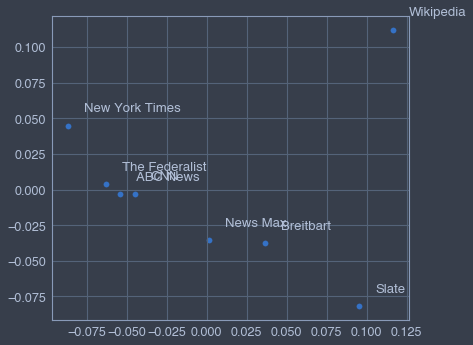

In [169]:
X_tranf = PCA(n_components=2).fit_transform(my_sum)
plt.scatter(X_tranf[:, 0], X_tranf[:, 1])
for index, word in enumerate(slices):
    plt.annotate(word, xy=(X_tranf[index, 0]+0.01, X_tranf[index, 1]+0.01))
plt.show()

In [178]:
print(np.array([[int((1 - cosine(my_sum[j], my_sum[i]))*100)/100
  for j in range(len(slices))] 
 for i in range(len(slices))]))

[[1.   0.91 0.98 0.94 0.94 0.94 0.93 0.97]
 [0.91 1.   0.95 0.98 0.99 0.98 0.92 0.97]
 [0.98 0.95 1.   0.98 0.97 0.97 0.95 0.99]
 [0.94 0.98 0.98 1.   0.99 0.98 0.93 0.99]
 [0.94 0.99 0.97 0.99 1.   0.99 0.92 0.99]
 [0.94 0.98 0.97 0.98 0.99 1.   0.92 0.98]
 [0.93 0.92 0.95 0.93 0.92 0.92 1.   0.94]
 [0.97 0.97 0.99 0.99 0.99 0.98 0.94 1.  ]]


In [171]:
for i, my_slice_1 in enumerate(slices):
    for j, my_slice_2 in enumerate(slices):
        print(i, j)
        print(1 - cosine(my_sum[j], my_sum[i]))

0 Slate
0.9386031627655029
1 New York Times
0.9241594672203064
2 Breitbart
0.9543775916099548
3 CNN
0.9339696764945984
4 ABC News
0.9299997687339783
5 The Federalist
0.9261355996131897
6 Wikipedia
1.0
7 News Max
0.9436805844306946
